## CNN Multi-chanel Model 

En este modelo utilizaremos las 8 variables disponibles en el dataset para entrenar una red neuronal convolucional que prediga una semana adelante para el Global Power Comsumption
Aquí, el modelo utiliza 8 kernels para evaluar cada una de las entradas, extrayendo las características separadamente 

Para esto, es necesario hacer unos ajustes en el modelo CNN univariate para que el vector de entrada contenga no solo la variable a predecir como en el modelo anterior, sino que tambien contenga las 8 variables. Las funciones modificadas son to_supervised y Forecast. 


In [1]:
from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

In [2]:
def split_dataset(data):
    # split into standard w     eeks 
    train, test = data[1:-328], data[-328:-6]
    # restructure into windows of weekly data
    train = array(split(train, len(train)/7))
    test = array(split(test, len(test)/7))
    return train, test

In [3]:
# evaluate a single model
def evaluate_model(train, test, n_input):
    # fit model
    model = build_model(train, n_input)
    model.summary()
    # history is a list of weekly data
    history = [x for x in train]
    # walk-forward validation over each week
    predictions = list()
    for i in range(len(test)):
        # predict the week
        yhat_sequence = forecast(model, history, n_input)
        # store the predictions
        predictions.append(yhat_sequence)
        # get real observation and add to history for predicting the next week
        history.append(test[i, :])
        # evaluate predictions days for each week
    predictions = array(predictions)
    score, scores = evaluate_forecasts(test[:, :, 0], predictions)
    return score, scores

In [5]:
# summarize scores
def summarize_scores(name, score, scores):
    s_scores = ', '.join(['%.1f' % s for s in scores])
    print('%s: [%.3f] %s' % (name, score, s_scores))
# split a univariate dataset into train/test sets

In [6]:
# split a univariate dataset into train/test sets
def evaluate_forecasts(actual, predicted):
    scores = list()
    # calculate an RMSE score for each day
    for i in range(actual.shape[1]):
        # calculate mse
        mse = mean_squared_error(actual[:, i], predicted[:, i])
        # calculate rmse
        rmse = sqrt(mse)
        # store
        scores.append(rmse)
        # calculate overall RMSE
    s = 0
    for row in range(actual.shape[0]):
        for col in range(actual.shape[1]):
            s += (actual[row, col] - predicted[row, col])**2
    score = sqrt(s / (actual.shape[0] * actual.shape[1]))
    return score, scores

#### En la función to Supervice vamos a ajustar el vector X para que contenga todas las variables )

In [11]:
def to_supervised(train, n_input, n_out=7):
    # flatten data
    data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
    X, y = list(), list()
    in_start = 0
    # step over the entire history one time step at a time
    for _ in range(len(data)):
        # define the end of the input sequence
        in_end = in_start + n_input
        out_end = in_end + n_out
        # ensure we have enough data for this instance
        if out_end < len(data):
            X.append(data[in_start:in_end, : ])
            y.append(data[in_end:out_end, 0])
    # move along one time step
        in_start += 1
    return array(X), array(y)

#### La función forecast tambien deberá modificar la variable del vector de entrada para que reciba las 8 variables del dataset

In [10]:
def forecast(model, history, n_input):
    # flatten data
    data = array(history)
    data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
    # retrieve last observations for input data
    input_x = data[-n_input:, : ]
    # reshape into [1, n_input, 1]
    input_x = input_x.reshape((1, input_x.shape[0] ,  input_x.shape[1] ))
    # forecast the next week
    yhat = model.predict(input_x, verbose=0)
    # we only want the vector forecast
    yhat = yhat[0]
    return yhat

#### Vamos a dejar el mismo modelo como primera prueba con las siguientes características: 

Epochs: 30 

batchsize: 8 

Capas convolucionales: 1 

Filtros: 32

Kernel size: 3

Funcion de activacion: Relu 

Capas densa: 30 neuronas

capa densa: 15 neuronas

In [43]:
def build_model(train, n_input):
    # prepare data
    train_x, train_y = to_supervised(train, n_input)
    # define parameters
    verbose, epochs, batch_size = 1, 100, 16
    n_outputs=7
    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], n_outputs
    # define model
    model = Sequential()
    model.add(Conv1D(filters=8, kernel_size=3, activation='relu',input_shape=(n_timesteps,n_features)))
    model.add(Conv1D(filters=16, kernel_size=3, activation='relu'))
    # model.add(MaxPooling1D(pool_size=2))
    # model.add(Conv1D(filters=16, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(40, activation='relu'))
    model.add(Dense(n_outputs))
    model.compile(loss='mse', optimizer='adam')
    # fit network
    model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
    return model

Epoch 1/100
69/69 [==============================] - 1s 2ms/step - loss: 235696053.7143
Epoch 2/100
69/69 [==============================] - 0s 2ms/step - loss: 526892.2129
Epoch 3/100
69/69 [==============================] - 0s 2ms/step - loss: 449302.9170
Epoch 4/100
69/69 [==============================] - 0s 2ms/step - loss: 472683.3420
Epoch 5/100
69/69 [==============================] - 0s 2ms/step - loss: 476332.4241
Epoch 6/100
69/69 [==============================] - 0s 2ms/step - loss: 446299.6973
Epoch 7/100
69/69 [==============================] - 0s 2ms/step - loss: 446554.9817
Epoch 8/100
69/69 [==============================] - 0s 2ms/step - loss: 458072.5902
Epoch 9/100
69/69 [==============================] - 0s 2ms/step - loss: 425889.8286
Epoch 10/100
69/69 [==============================] - 0s 2ms/step - loss: 436419.1420
Epoch 11/100
69/69 [==============================] - 0s 2ms/step - loss: 422389.4205
Epoch 12/100
69/69 [==============================] - 0s 2ms

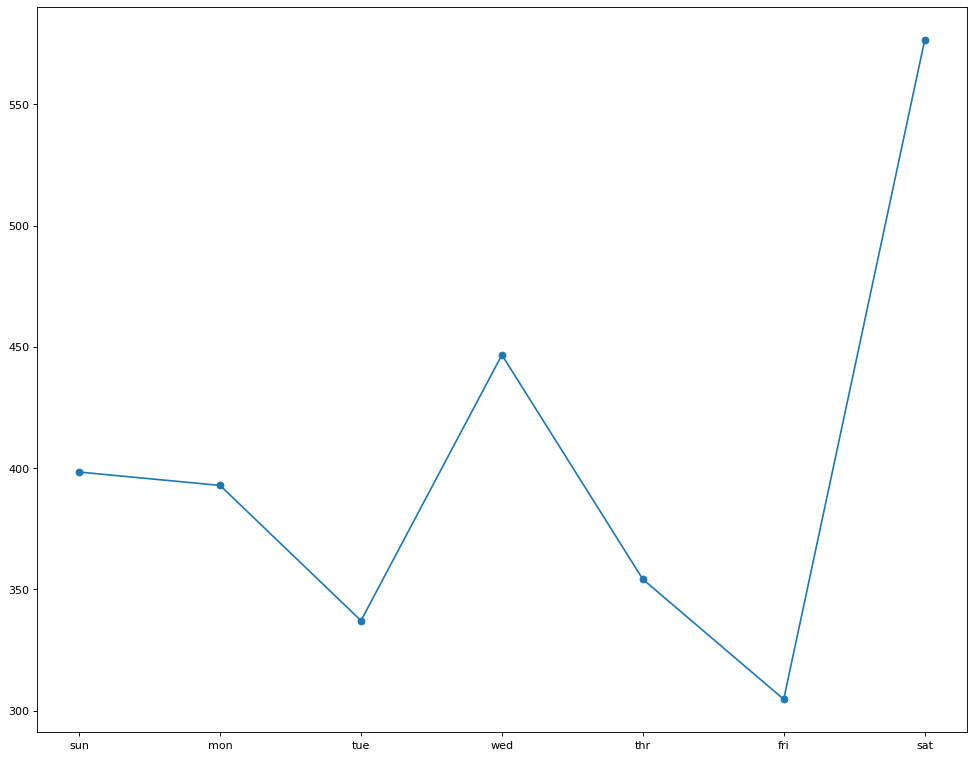

In [44]:
# load the new file
dataset = read_csv('household_power_consumption_days.csv', header=0,
infer_datetime_format=True, parse_dates=['datetime'], index_col=['datetime'])
# split into train and test
train, test = split_dataset(dataset.values)
# evaluate model and get scores
n_input = 14
score, scores = evaluate_model(train, test, n_input)
# summarize scores
summarize_scores('cnn', score, scores)
# plot scores
days = ['sun', 'mon', 'tue', 'wed', 'thr', 'fri', 'sat']
pyplot.figure(figsize=(15,12), dpi=80)
pyplot.plot(days, scores, marker='o', label='cnn')
pyplot.show()

In [24]:
train.shape

(159, 7, 8)